In [1]:
import sys
import getpass
import os
import pandas as pd
import fiona
import geopandas as gpd
from arcgis import gis
import requests
username = getpass.getuser()

user = getpass.getuser()
sys.dont_write_bytecode = True

# for DataViz team members
sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [2]:
data_dir = 'data'
data_output_dir = 'data/geojson'

In [3]:
client = gis.GIS(url='https://arcgis.ad.mtc.ca.gov/portal/home/',username=username,verify_cert=False)

Enter password: ········


## Read jurisdiction boundary fc

In [4]:
ba_cty_gdf = gpd.read_file(os.path.join(data_dir,'Jurisdiction_Boundary_Database.gdb'),
                             driver='FileGDB',
                             layer='Bay_Area_Counties_TIGER_2020')

## Create single-family zoning dataset

In [12]:
#Read parcels from socrata
parcels_geojson = pull_geojson_from_socrata('a9e8-6mw3')

pulling 2062822 rows as geojson
took 8.9484 minutes


In [13]:
#Create parcels gdf from geojson
parcels_gdf = gpd.GeoDataFrame.from_features(parcels_geojson['features'],
                                             crs='EPSG:4326')

In [3]:
#Pull zoning and parcel base table from redshift
sql = """
SELECT a.*,b.geo_id_pa,b.zn_recid 
from basis_staging.zn_base_tbl a 
join basis_staging.parcel_base_tbl b ON a.zn_recid = b.zn_recid 
where zn_regional_code = 2
"""
zoning = pull_df_from_redshift_sql(sql_statement=sql)

took 36.513 seconds


In [4]:
#Remove duplicated column
zoning = zoning.loc[:,~zoning.columns.duplicated()]

In [5]:
zoning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050999 entries, 0 to 1050998
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   zn_recid                 1050999 non-null  object 
 1   zn_code                  1050999 non-null  object 
 2   zn_description           811971 non-null   object 
 3   zn_regional_code         1050999 non-null  float64
 4   zn_regional_description  1050999 non-null  object 
 5   zn_code_basis_url        1034222 non-null  object 
 6   zn_code_map_url          1031438 non-null  object 
 7   zn_effective_date        0 non-null        object 
 8   zn_map_color             153552 non-null   object 
 9   zn_county                1050999 non-null  object 
 10  zn_jurisdiction          1034222 non-null  object 
 11  allows_residential       1050999 non-null  float64
 12  editor_id                1050999 non-null  object 
 13  last_edited              1050999 non-null 

In [32]:
#Join parcels to zoning 
parcels_zoning = pd.merge(parcels_gdf,
                          zoning,
                          left_on='geo_id',
                          right_on='geo_id_pa',
                          how='outer',
                          indicator=True)

In [33]:
parcels_zoning.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2089639 entries, 0 to 2089638
Data columns (total 26 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   geometry                 geometry
 1   jurisdiction             object  
 2   y_3857                   object  
 3   parcel_type              object  
 4   city_soi                 object  
 5   county                   object  
 6   geo_id                   object  
 7   x_3857                   object  
 8   parcel_id                object  
 9   zn_recid                 object  
 10  zn_code                  object  
 11  zn_description           object  
 12  zn_regional_code         float64 
 13  zn_regional_description  object  
 14  zn_code_basis_url        object  
 15  zn_code_map_url          object  
 16  zn_effective_date        object  
 17  zn_map_color             object  
 18  zn_county                object  
 19  zn_jurisdiction          object  
 20  allows_residenti

In [37]:
single_fam_by_jurs = zoning.groupby(['zn_county','zn_jurisdiction']).size().sort_values().reset_index()

In [39]:
single_fam_by_jurs.to_csv('data/single_family_parcels_by_jurisdiction.csv')

In [30]:
single_fam_by_jurs[single_fam_by_jurs['zn_jurisdiction'] == 'Yountville']

,zn_jurisdiction,0
3,Yountville,430


In [31]:
parcels_zoning[(parcels_zoning['zn_jurisdiction'] == 'Yountville') & 
               (parcels_zoning['zn_regional_code'] == 2)].shape

(2, 26)

In [41]:
(parcels_zoning[parcels_zoning['zn_county'] == 'Napa']
 .groupby(['zn_jurisdiction','_merge'])
 .size()
 .sort_values()
 .reset_index())

,zn_jurisdiction,_merge,0
0,Calistoga,left_only,0
1,Napa,left_only,0
2,St Helena,left_only,0
3,St Helena,both,0
4,Unincorporated Napa,left_only,0
5,Yountville,left_only,0
6,Calistoga,both,2
7,Yountville,both,2
8,Unincorporated Napa,both,11
9,Napa,both,64


In [62]:
out_cols = [
    'geo_id_pa',
    'jurisdiction',
    'county',
    'zn_recid',
    'zn_code',
    'zn_description',
    'zn_regional_code',
    'zn_regional_description',
    'zn_county',
    'zn_jurisdiction',
    'allows_residential',
    'editor_id',
    'edit_version',
     'geometry'
]
parcels_zoning[out_cols].to_file(os.path.join(data_output_dir,'single_family_zoning_2021.geojson'),
                                          driver='GeoJSON')

## Create hazardous waste site geojson

In [16]:
os.listdir(os.path.join(data_dir,'EnviroStorHazardousWaste'))

['hazardous_waste_facilities.txt',
 'hazardous_waste_units_completed_activities.txt',
 'maintenance.txt',
 'units.txt',
 'contacts.txt',
 'alias.txt',
 'financial_assurance_summary.txt',
 'readme.txt',
 'work_request_data.txt',
 'permitting_project_status.txt',
 'hazardous_waste_units_undergoing_closure.txt']

In [20]:
haz_waste_df = pd.read_csv(os.path.join(data_dir,'EnviroStorHazardousWaste','hazardous_waste_facilities.txt'),
                           sep='\t',
                           encoding='cp1252')

In [21]:
haz_waste_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EPA_ID                             902 non-null    object 
 1   FACILITY_NAME                      902 non-null    object 
 2   ADDRESS                            902 non-null    object 
 3   CITY                               902 non-null    object 
 4   STATE                              902 non-null    object 
 5   ZIP                                902 non-null    int64  
 6   COUNTY                             902 non-null    object 
 7   LATITUDE                           902 non-null    float64
 8   LONGITUDE                          902 non-null    float64
 9   FACILITY_TYPE                      902 non-null    object 
 10  FACILITY_STATUS                    902 non-null    object 
 11  SUPERVISOR                         141 non-null    object 

In [25]:
#convert df w/ lat long to gdf
haz_waste_gdf = gpd.GeoDataFrame(haz_waste_df,
                                 geometry=gpd.points_from_xy(haz_waste_df.LONGITUDE, 
                                                             haz_waste_df.LATITUDE),
                                 crs='EPSG:4326')

In [27]:
#Export to GeoJSON
haz_waste_gdf.to_file(os.path.join(data_output_dir,'hazardous_waste_sites.geojson'),
                      driver='GeoJSON')

## Create urbanized area urbanized cluster geojson

In [68]:
os.listdir(os.path.join(data_dir,'tl_2020_us_uac10'))

['tl_2020_us_uac10.shp.iso.xml',
 'tl_2020_us_uac10.prj',
 'tl_2020_us_uac10.dbf',
 'tl_2020_us_uac10.cpg',
 'tl_2020_us_uac10.shp',
 'tl_2020_us_uac10.shp.ea.iso.xml',
 'tl_2020_us_uac10.shx']

In [70]:
urban_area_gdf = gpd.read_file(os.path.join(data_dir,'tl_2020_us_uac10.zip'))

In [74]:
urban_area_gdf.to_crs('EPSG:4326',inplace=True)

In [79]:
urban_area_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [82]:
ba_urban_areas_gdf = gpd.clip(urban_area_gdf,ba_cty_gdf)

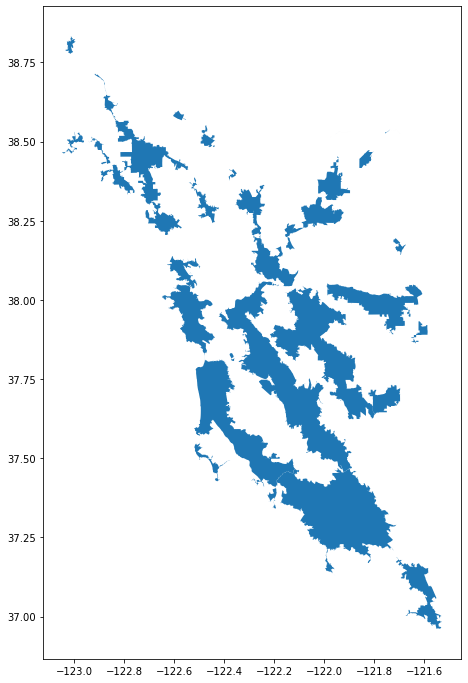

In [84]:
ba_urban_areas_gdf.plot(figsize=(10,12));

In [85]:
ba_urban_areas_gdf.to_file(os.path.join(data_output_dir,'ba_urban_areas.geojson'),
                      driver='GeoJSON')

In [91]:
variables_list = [zoning,
                  urban_area_gdf,
                  ba_urban_areas_gdf,
                  parcels_gdf,
                  parcels_geojson,
                  parcels_zoning,
                  haz_waste_df,
                  haz_waste_gdf]

## Create FMMP geojson

In [94]:
fmmp_gdf = pull_geodata_from_argis(arcgis_data_id='d57abc5f879f4ac8a2c02047b22bd6e2',
                                   client=client)

In [98]:
county = ['San Francisco',
          'San Mateo',
          'Santa Clara',
          'Alameda',
          'Contra Costa',
          'Solano',
          'Napa',
          'Sonoma',
          'Marin']

(fmmp_gdf[(fmmp_gdf['county'].isin(county)) & 
         (fmmp_gdf['polygon_ty'] == 'S')]
 .to_file(os.path.join(data_output_dir,'ba_fmmp.geojson'),
          driver='GeoJSON'))

In [99]:
del fmmp_gdf

## Create very high and high fire severity geojson

In [7]:
fire_haz_gdf = pull_geodata_from_argis('0796bcb0369f41758715a2bda6cade11',
                                   client=client)

In [13]:
(fire_haz_gdf[fire_haz_gdf['haz_class'].isin(['Very High','High'])]
 .to_file(os.path.join(data_output_dir,'ba_fire_severity_zones.geojson'),
          driver='GeoJSON'))

## Create flood zone geojson

In [14]:
flood_zone_gdf = pull_geodata_from_argis('3e2ba5cf735545d1babc592c509379fb',
                                         client=client)

In [23]:
(flood_zone_gdf[flood_zone_gdf['fld_zone'].isin(['A', 'A99', 'AE', 'AH', 'AO', 'V', 'VE'])]
 .to_file(os.path.join(data_output_dir,'flood_zones.geojson'),
          driver='GeoJSON'))